In [87]:
import os
import sys
sys.path.extend(['..'])

import itertools
import random
import time
import unittest.mock as mock

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_probability as tfp
import tensorboard
%load_ext tensorboard

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

cpus = tf.config.list_physical_devices(device_type='CPU')
tf.config.set_visible_devices(devices=cpus, device_type='CPU')

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [88]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.plot_game import plot_game

## Check that gradients can flow across channel:

In [3]:
channel = CommChannel(size=10, temperature=1, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[5.2433362e-04 5.9039764e-02 9.3405348e-01 6.3824272e-03]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [4]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [5]:
NUM_CLASSES = 3
BATCH_SIZE = 32
use_mnist = False

if use_mnist:
    class_labels = list(range(NUM_CLASSES))
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    def preprocess_images(images):
        images = images / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

    x_train = preprocess_images(x_train)
    train_data = [(x, y) for x, y in zip(x_train, y_train) if y in class_labels]
    np.random.shuffle(train_data)

    x_test = preprocess_images(x_test)
    test_data = [(x, y) for x, y in zip(x_test, y_test) if y in class_labels]
    np.random.shuffle(test_data)
    
else:
    class_labels = list(range(1, 1 + NUM_CLASSES))
    sample_size = int(np.ceil(np.log2(NUM_CLASSES)))
    train_data = [
        ([0.0]*(sample_size - len(bin(l)) + 2) + [float(x) for x in bin(l)[2:]], l)
        for l in range(1, NUM_CLASSES+1)
    ]
    test_data = train_data


train_data_by_label = {
    label: [
        img for img, l in train_data
        if l == label
    ]
    for label in class_labels
}

test_data_by_label = {
    label: [
        img for img, l in test_data
        if l == label
    ]
    for label in class_labels
}

In [6]:
train_data_by_label

{1: [[0.0, 1.0]], 2: [[1.0, 0.0]], 3: [[1.0, 1.0]]}

In [7]:
def generate_batch(source, source_by_label, batch_size=BATCH_SIZE):
    inputs = []
    targets = []
    
    
    for batch in range(batch_size):
        batch_tars = []
        batch_inps = []
        
        for ts in range(NUM_CLASSES):
            sample_space = set(class_labels) - set(batch_tars)
            target = random.choice(list(sample_space))
            batch_tars.append(target)
            inp = random.choice(source_by_label[target])
            batch_inps.append(tf.constant(inp))
        
        target = random.choice(list(set(class_labels)))  
        batch_tars.append(target)
        inp = random.choice(source_by_label[target])
        batch_inps.append(tf.constant(inp))
        
        batch_tars = [
            tf.one_hot(tar-1, NUM_CLASSES)
            for tar in batch_tars
        ]
        
        inputs.append(batch_inps)
        targets.append(batch_tars)
    
    inputs = [
        tf.concat([[inputs[b][t]] for b in range(batch_size)], 0)
        for t in range(NUM_CLASSES + 1)
    ]
    inputs = tf.convert_to_tensor(inputs)
    
    targets = [
        tf.concat([[targets[b][t]] for b in range(batch_size)], 0)
        for t in range(NUM_CLASSES + 1)
    ]
    targets = tf.convert_to_tensor(targets)
    
    return inputs, targets 

def generate_train_batch():
    return generate_batch(train_data, train_data_by_label)

def generate_test_batch():
    return generate_batch(test_data, test_data_by_label)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

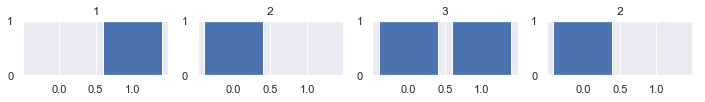

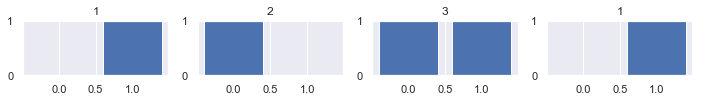

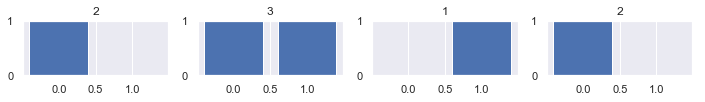

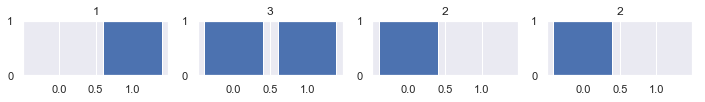

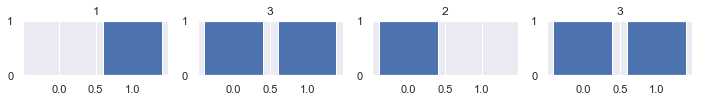

In [10]:
if use_mnist:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for ax, inp, tar in zip(axs, inputs, targets):
        ax.set_title(tar[row].numpy().argmax() + 1)
        if use_mnist:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), 
                              comm_channel.size, history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[3, 1, 4, 0],
       [2, 1, 4, 3],
       [4, 3, 2, 0],
       [4, 0, 2, 3],
       [1, 0, 4, 3]], dtype=int64)>

## Construct Model

In [12]:
if use_mnist:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    encoder = None

CHANNEL_SIZE = 5

agent_1 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)
agent_2 = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

In [13]:
inputs, _ = generate_train_batch()
preds, history = play_game(inputs, agent_1, agent_1)

Check gradients:

In [14]:
inputs, targets = generate_train_batch()

teacher = agent_1
student = agent_2

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        p_mutate=0.5)

    loss = combined_loss_fn(outputs, targets)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(agent_1.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(agent_1.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 0.07476114481687546
agent/dense/bias:0 teacher grad norm: 0.06046360731124878
agent/lstm/kernel:0 teacher grad norm: 0.12522856891155243
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.020609842613339424
agent/lstm/bias:0 teacher grad norm: 0.05233483389019966
agent/dense_1/kernel:0 teacher grad norm: 0.05047430470585823
agent/dense_1/bias:0 teacher grad norm: 0.08235085755586624

agent/dense/kernel:0 student grad norm: 0.07476114481687546
agent/dense/bias:0 student grad norm: 0.06046360731124878
agent/lstm/kernel:0 student grad norm: 0.12522856891155243
agent/lstm/recurrent_kernel:0 student grad norm: 0.020609842613339424
agent/lstm/bias:0 student grad norm: 0.05233483389019966
agent/dense_1/kernel:0 student grad norm: 0.05047430470585823
agent/dense_1/bias:0 student grad norm: 0.08235085755586624


In [15]:
agent_1.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, agent_1, agent_2,
                    p_mutate=0.5, 
                    training=False)

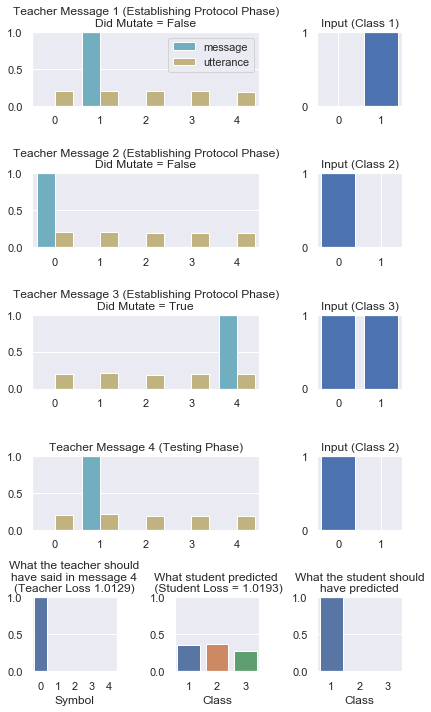

In [17]:
plot_game(inputs, outputs, targets, select_batch=1)

In [18]:
inputs, targets = generate_train_batch()

teacher = agent_1
student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(agent_1.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 1.8872894048690796
agent/dense/bias:0 teacher grad norm: 1.714418649673462
agent/lstm/kernel:0 teacher grad norm: 3.050219774246216
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.33578288555145264
agent/lstm/bias:0 teacher grad norm: 1.2408651113510132
agent/dense_1/kernel:0 teacher grad norm: 1.3975156545639038
agent/dense_1/bias:0 teacher grad norm: 2.3483028411865234


# Run Experiments

In [237]:
class Experiment:
    
    def __init__(
        self, 
        play_params=None,
        teacher=None, 
        student=None,
        loss_fn=complete_loss_fn,
        loss_kwargs=None,
        student_loss_fn=None,
        teacher_loss_fn=None,
        max_epochs=40, 
        steps_per_epoch=50, 
        step_print_freq=5,
        test_freq=5,
        test_steps=25,
        lr=1e-2, # learning rate
    ):
        self.play_params = play_params or dict()
        self.student = student
        self.teacher = teacher
            
        self.loss_fn = loss_fn
        self.loss_kwargs = loss_kwargs or dict()
        
        self.max_epochs = max_epochs
        self.steps_per_epoch = steps_per_epoch
        self.step_print_freq = step_print_freq
        self.test_freq = test_freq
        self.test_steps = test_steps
        
        self.training_history = []
        self.epoch = 0
        self.optimiser_1 = tf.keras.optimizers.RMSprop(learning_rate=lr)
        self.optimiser_2 = tf.keras.optimizers.RMSprop(learning_rate=lr)
        
        self.optimise_separately = (student_loss_fn is not None) or \
                                   (teacher_loss_fn is not None)
        self.student_loss_fn = student_loss_fn or loss_fn
        self.teacher_loss_fn = teacher_loss_fn or loss_fn
        
    def get_trainable_variables(self):
        if self.student is not None and self.teacher is None:
            return self.student.trainable_variables
        elif self.student is None and self.teacher is not None:
            return self.teacher.trainable_variables
        elif self.student == self.teacher:
            return self.student.trainable_variables
        else:
            return self.student.trainable_variables + \
                   self.teacher.trainable_variables

    def training_step(self):
        inputs, targets = generate_train_batch()
        
        student = self.student or \
            mock.MagicMock(return_value=(None, None, None))
        
        teacher = self.teacher or \
            SyntheticTeacher(CHANNEL_SIZE, NUM_CLASSES, targets)
    
        with tf.GradientTape(persistent=True) as tape:
            outputs = play_game(
                inputs, teacher, student, 
                training=True, 
                **self.play_params
            )

            if self.optimise_separately:
                loss_s = self.student_loss_fn(outputs, targets)
                loss_t = self.teacher_loss_fn(outputs, targets)
                loss = loss_s + loss_t
            else:
                loss = self.loss_fn(outputs, targets)

        if self.optimise_separately:
            trainable_vars_s = self.student.trainable_variables
            grads_s = tape.gradient(loss_s, trainable_vars_s)
            self.optimiser_1.apply_gradients(zip(grads_s, trainable_vars_s))
            
            trainable_vars_t = self.teacher.trainable_variables
            grads_t = tape.gradient(loss_t, trainable_vars_t)
            self.optimiser_2.apply_gradients(zip(grads_t, trainable_vars_t))
        else:
            trainable_vars = self.get_trainable_variables()
            grads = tape.gradient(loss, trainable_vars)
            self.optimiser_1.apply_gradients(zip(grads, trainable_vars))
    
        return loss
    
    def get_test_loss(self, games_played):
        test_loss = tf.reduce_mean([
            self.loss_fn(outputs, targets, **self.loss_kwargs)
            for _, targets, outputs in games_played
        ])
        return float(test_loss.numpy())
    
    def get_student_test_metrics(self, games_played):
        
        ground_truth_labels = tf.concat([
            tf.argmax(targets[-1], axis=-1) 
            for _, targets, _ in games_played
        ], axis=0)

        preds = tf.concat([
            tf.argmax(student_preds, axis=-1) 
            for _, _, (student_preds, _) in games_played
        ], axis=0)
        
        correct_preds = [
            get_expected_student_pred(outputs, targets)
            for (_, targets, outputs) in games_played
        ]
        
        mean_ground_truth_f1 = f1_score(
            ground_truth_labels.numpy(), preds.numpy(), 
            average='micro'
        )
        mean_ground_truth_f1 = float(mean_ground_truth_f1)
        
        mean_student_kld = tf.reduce_mean([
            tf.metrics.kld(actual, correct)
            for actual, correct in zip(preds, correct_preds)
        ])
        mean_student_kld = float(mean_student_kld.numpy())
        
        return mean_ground_truth_f1, mean_student_kld
    
    def get_teacher_test_metrics(self, games_played):
        
        correct_teacher_test_msgs = tf.concat([
            get_correct_teacher_msg(game_history, targets)
            for _, targets, (_, game_history) in games_played
        ], axis=0)
        
        actual_teacher_test_msgs = tf.concat([
            game_history[-1]['message_from_teacher']
            for _, targets, (_, game_history) in games_played
        ], axis=0)
        
        mean_teacher_kld = tf.reduce_mean([
            tf.metrics.kld(actual, correct)
            for actual, correct in zip(actual_teacher_test_msgs, 
                                       correct_teacher_test_msgs)
        ])
        mean_teacher_kld = float(mean_teacher_kld.numpy())
        
        return mean_teacher_kld
    
    def test_play(self, inputs):
        
        student = self.student or \
            mock.MagicMock(return_value=(None, None, None))
        teacher = self.teacher or \
            SyntheticTeacher(CHANNEL_SIZE, NUM_CLASSES, targets)
        
        return play_game(inputs, teacher, student, 
                         training=False,
                         **self.play_params)
    
    def run_tests(self):
        
        test_samples = [
            generate_test_batch()
            for _ in range(self.test_steps)
        ]

        games_played = [
            (inp, tar, self.test_play(inp))
            for inp, tar in test_samples
        ]
        
        mean_ground_truth_f1, mean_student_kld = \
            self.get_student_test_metrics(games_played)
        
        mean_teacher_kld = \
            self.get_teacher_test_metrics(games_played)
            
        test_metrics = {
            'mean_test_loss': self.get_test_loss(games_played), 
            'mean_ground_truth_f1': mean_ground_truth_f1,
            'mean_student_kld': mean_student_kld,
            'mean_teacher_kld': mean_teacher_kld
        }
        
        return games_played, test_metrics
    
    def train(self):
        self.print_history()
        clear_output(wait=True)
        try:
            while self.epoch < self.max_epochs:
                mean_loss = tf.zeros((1,))

                start_time = time.time()
                for step in range(self.steps_per_epoch):

                    loss = self.training_step()
                    mean_loss = (mean_loss + tf.reduce_mean(loss)) / 2.0

                    if step % self.step_print_freq == 0:
                        self.print_history()
                        self.print_step_progress(step, mean_loss)
                        clear_output(wait=True)

                seconds_taken = time.time() - start_time
                self.training_history.append({
                    'loss': float(mean_loss.numpy().mean()), 
                    'seconds_taken': seconds_taken
                })
                
                if self.epoch % self.test_freq == 0:
                    self.print_history()
                    print('Running test games...')
                    clear_output(wait=True)
                    _, test_metrics = self.run_tests()
                    self.training_history[-1]['test_metrics'] = test_metrics
                    
                self.epoch += 1
                self.print_history()
                clear_output(wait=True)

        except KeyboardInterrupt:
            pass

        self.print_history()
        print('Training stopped.')
    
    def get_config(self):
        return {
            'max_epochs': self.max_epochs,
            'steps_per_epoch': self.steps_per_epoch,
            'epochs_optimised': self.epoch,
            'loss_fn': self.loss_fn.__name__,
            'play_params': self.play_params,
            'test_freq': self.test_freq,
            'test_steps': self.test_steps,
            'optimiser_config': self.optimiser_1.get_config(),
        }
    
    def print_history(self):
        for e, item in enumerate(self.training_history):
            mins = int(item['seconds_taken']) // 60
            secs = int(item['seconds_taken']) % 60
            loss = round(item['loss'], 3)
            print(f'Epoch {e}, Time Taken (mm:ss): {mins}:{secs}, Mean Loss: {loss}')
            if 'test_metrics' in item:
                metrics = item['test_metrics']
                print(
                    f"Test Loss: {round(metrics['mean_test_loss'], 3)},",
                    f"Ground Truth F1-Score: {round(metrics['mean_ground_truth_f1'], 3)},",
                    f"Student Divergence: {round(metrics['mean_student_kld'], 3)},",
                    f"Teacher Divergence: {round(metrics['mean_teacher_kld'], 3)}"
                )

    def print_step_progress(self, step, step_mean_loss):
        l = round(float(step_mean_loss.numpy().mean()), 4)
        p = round(100 * step / self.steps_per_epoch, 2)
        print(f'Epoch {self.epoch}, {p}% complete, Loss: {l}')

In [238]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': 1, 'stop_gradients_on_all_comm': True}
    
    return Experiment(
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': 0}
    
    return Experiment(
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o)
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': p_mutate}
    
    return Experiment(
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class
    )

def create_self_play_experiment(p_mutate=0.3):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=encoder)

    play_params =  {'p_mutate': p_mutate3}
    
    return Experiment(
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn
    )

In [239]:
experiment_op_sep_opt = create_other_play_separate_optimise_experiment()

In [240]:
experiment_op_sep_opt.train()

Epoch 0, Time Taken (mm:ss): 0:17, Mean Loss: 1.315
Test Loss: 4.983, Ground Truth F1-Score: 0.701, Student Divergence: 14.516, Teacher Divergence: 3.949
Epoch 1, Time Taken (mm:ss): 0:17, Mean Loss: 1.561
Epoch 2, Time Taken (mm:ss): 0:27, Mean Loss: 1.395
Epoch 3, Time Taken (mm:ss): 0:25, Mean Loss: 1.507
Epoch 4, Time Taken (mm:ss): 0:16, Mean Loss: 1.782
Epoch 5, Time Taken (mm:ss): 0:17, Mean Loss: 1.188
Test Loss: 5.159, Ground Truth F1-Score: 0.606, Student Divergence: 16.574, Teacher Divergence: 4.07
Epoch 6, Time Taken (mm:ss): 0:17, Mean Loss: 1.788
Epoch 7, Time Taken (mm:ss): 0:17, Mean Loss: 0.563
Epoch 8, Time Taken (mm:ss): 0:20, Mean Loss: 0.611
Epoch 9, Time Taken (mm:ss): 0:18, Mean Loss: 0.589
Epoch 10, Time Taken (mm:ss): 0:17, Mean Loss: 0.824
Test Loss: 4.425, Ground Truth F1-Score: 0.769, Student Divergence: 13.679, Teacher Divergence: 3.546
Epoch 11, Time Taken (mm:ss): 0:17, Mean Loss: 0.539
Epoch 12, Time Taken (mm:ss): 0:18, Mean Loss: 0.755
Epoch 13, Time T

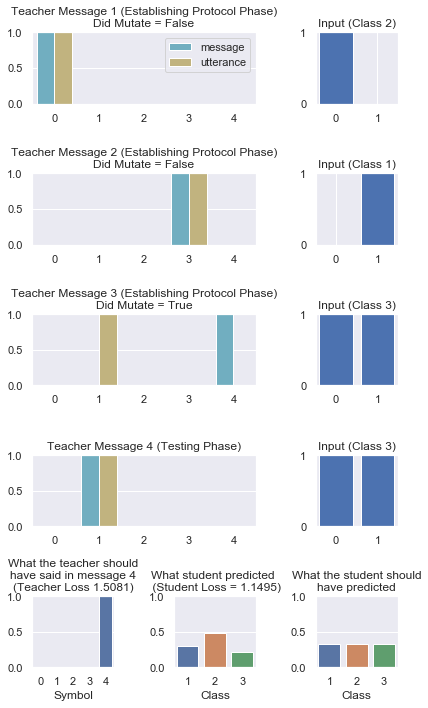

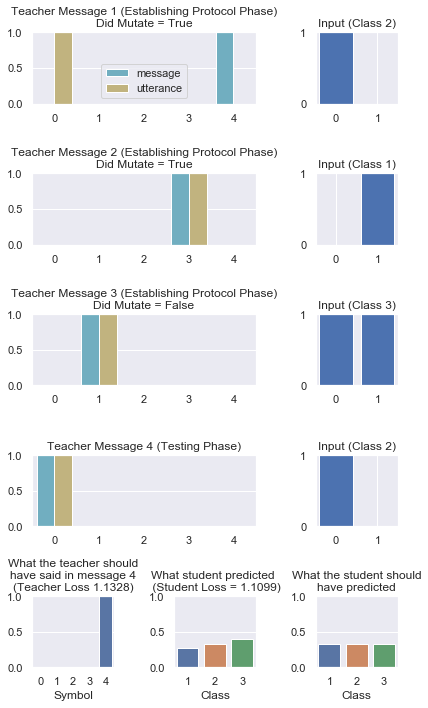

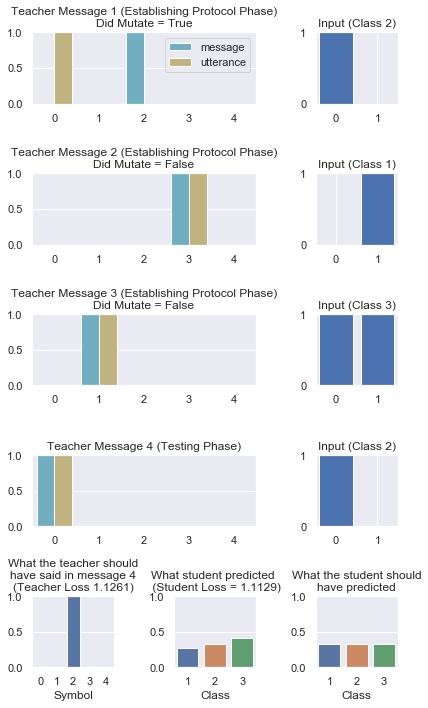

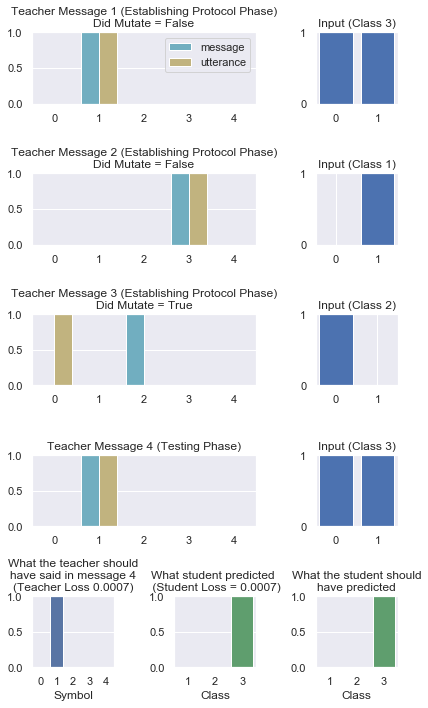

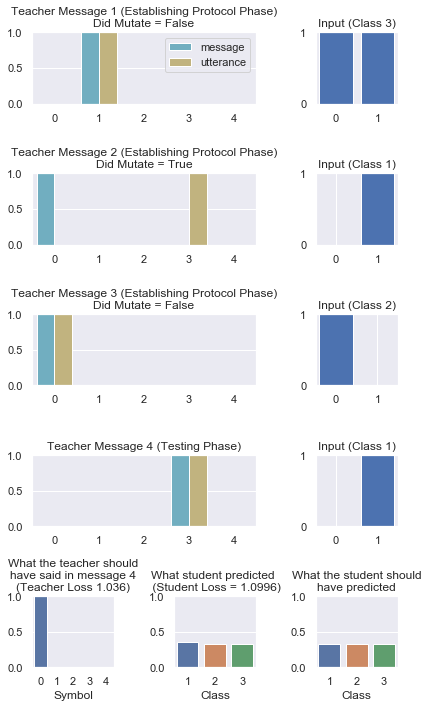

In [243]:
games_played, test_metrics = experiment_op_sep_opt.run_tests()
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [ ]:
experiment = create_self_play_experiment()
print(experiment.get_config())

In [157]:
experiment.train()

Epoch 0, Time Taken (mm:ss): 0:13, Mean Loss: 3.8529999256134033
Test Loss: 4.204999923706055, Ground Truth F1-Score: 0.326, Student Divergence: 12.447999954223633, Teacher Divergence: 3.3239998817443848
Epoch 1, Time Taken (mm:ss): 0:15, Mean Loss: 3.8559999465942383
Epoch 2, Time Taken (mm:ss): 0:14, Mean Loss: 3.8289999961853027
Epoch 3, Time Taken (mm:ss): 0:13, Mean Loss: 3.755000114440918
Epoch 4, Time Taken (mm:ss): 0:13, Mean Loss: 3.822000026702881
Epoch 5, Time Taken (mm:ss): 0:13, Mean Loss: 3.7860000133514404
Test Loss: 3.9560000896453857, Ground Truth F1-Score: 0.321, Student Divergence: 20.979000091552734, Teacher Divergence: 6.3460001945495605
Epoch 6, Time Taken (mm:ss): 0:14, Mean Loss: 3.7190001010894775
Epoch 7, Time Taken (mm:ss): 0:16, Mean Loss: 3.742000102996826
Epoch 8, Time Taken (mm:ss): 0:13, Mean Loss: 3.618000030517578
Epoch 9, Time Taken (mm:ss): 0:14, Mean Loss: 3.515000104904175
Epoch 10, Time Taken (mm:ss): 0:14, Mean Loss: 3.3239998817443848
Test Loss:

In [186]:
experiment2 = create_self_play_experiment()

In [187]:
experiment2.train()

Epoch 0, Time Taken (mm:ss): 0:13, Mean Loss: 3.838
Test Loss: 4.31, Ground Truth F1-Score: 0.319, Student Divergence: 10.799, Teacher Divergence: 2.881
Epoch 1, Time Taken (mm:ss): 0:14, Mean Loss: 3.827
Epoch 2, Time Taken (mm:ss): 0:13, Mean Loss: 3.776
Epoch 3, Time Taken (mm:ss): 0:14, Mean Loss: 3.782
Epoch 4, Time Taken (mm:ss): 0:17, Mean Loss: 3.778
Epoch 5, Time Taken (mm:ss): 0:19, Mean Loss: 3.73
Test Loss: 3.769, Ground Truth F1-Score: 0.315, Student Divergence: 21.016, Teacher Divergence: 6.931
Epoch 6, Time Taken (mm:ss): 0:22, Mean Loss: 3.771
Epoch 7, Time Taken (mm:ss): 0:18, Mean Loss: 3.735
Epoch 8, Time Taken (mm:ss): 0:18, Mean Loss: 3.639
Epoch 9, Time Taken (mm:ss): 0:15, Mean Loss: 3.648
Epoch 10, Time Taken (mm:ss): 0:15, Mean Loss: 3.424
Test Loss: 3.149, Ground Truth F1-Score: 0.343, Student Divergence: 7.737, Teacher Divergence: 9.832
Epoch 11, Time Taken (mm:ss): 0:24, Mean Loss: 3.267
Epoch 12, Time Taken (mm:ss): 0:16, Mean Loss: 2.864
Epoch 13, Time Tak

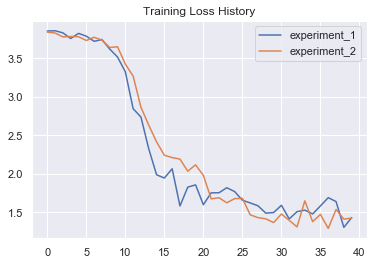

In [188]:
plt.figure()
plt.title('Training Loss History')
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='experiment_1');
sns.lineplot(x=range(len(experiment2.training_history)), 
             y=[item['loss'] for item in experiment2.training_history],
             label='experiment_2');

## Render Model Graph in Tensorboard

In [160]:
# # Set up logging.
# from datetime import datetime
# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)


# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [70]:
# %tensorboard --logdir logs

## Test Model

In [161]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.1794134,
 'mean_ground_truth_f1': 0.94125,
 'mean_student_kld': 23.008783,
 'mean_teacher_kld': 0.40295234}

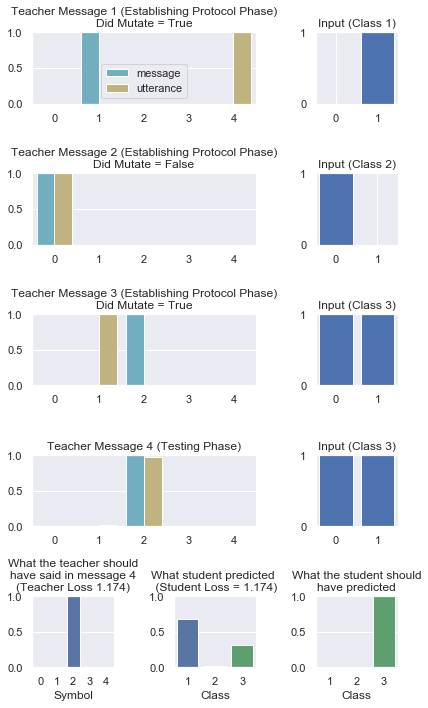

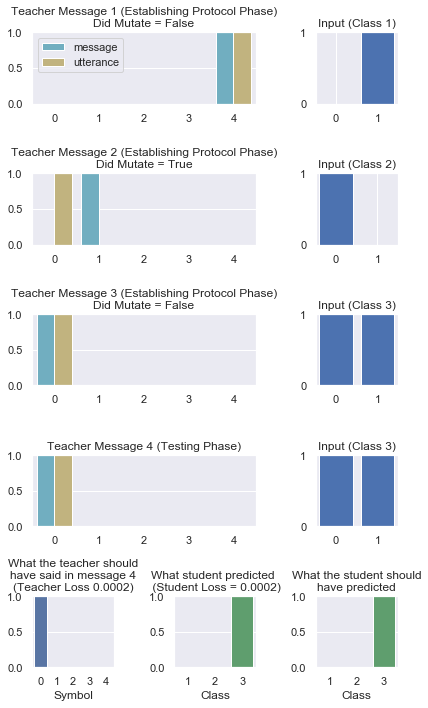

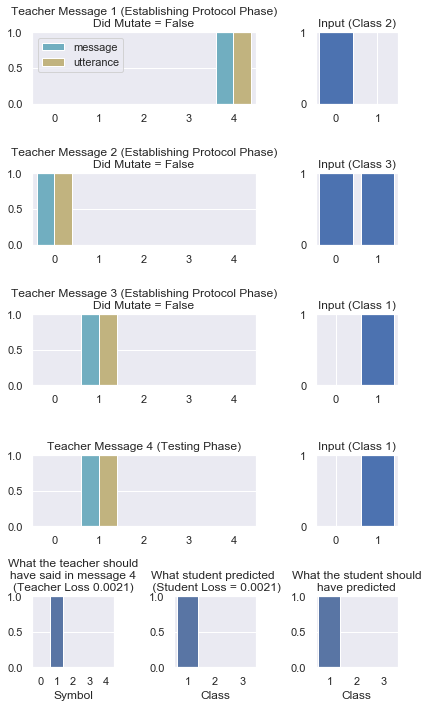

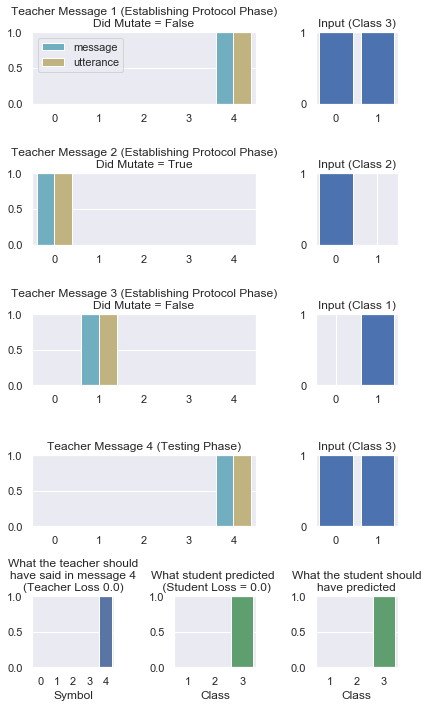

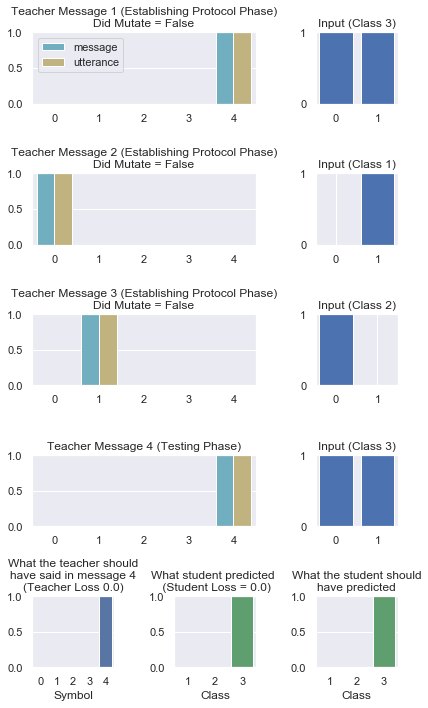

In [163]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

In [226]:
def compute_confusion_matrix(games_played):
    labels = tf.concat([
        tf.argmax(targets[-1], axis=-1) 
        for _, targets, _ in games_played
    ], axis=0)

    preds = tf.concat([
        tf.argmax(student_preds, axis=-1) 
        for _, _, (student_preds, _) in games_played
    ], axis=0)

    conf_matrix = tf.math.confusion_matrix(labels, preds)

    col_totals = tf.reduce_sum(conf_matrix, axis=0)
    col_totals = tf.repeat(col_totals, tf.shape(conf_matrix)[0])
    col_totals = tf.reshape(col_totals, tf.shape(conf_matrix))
    col_totals = tf.transpose(col_totals)

    conf_matrix = (conf_matrix / col_totals).numpy()
    conf_matrix[np.where(np.isnan(conf_matrix))] = 0
    
    return conf_matrix

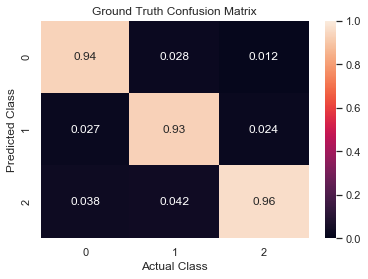

In [228]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

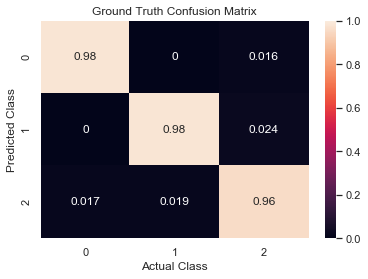

In [227]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

In [217]:
def make_map(label, message):
    *_, msg_size = tf.shape(message)
    lm_map_shape = (NUM_CLASSES, msg_size)
    class_indices = [i for i, _ in enumerate(class_labels)]
    indices = tf.reshape(tf.repeat(class_indices, msg_size), 
                         lm_map_shape)
    indices = tf.cast(indices, tf.int64) == label
    return message * tf.cast(indices, tf.float32)


def create_mean_class_message_map(games_played):
    """
    The mean label-message map is a representation of the 
    communication protocol being used for the test messages 
    being sent by the teacher. Each row correponds with a 
    class, each column corresponds with a symbol
    """
    messages = tf.concat([
        history[-1]['message_from_teacher'] 
        for *_, (_, history) in games_played
    ], axis=0)

    *_, msg_size = tf.shape(messages)
    lm_map = tf.zeros((NUM_CLASSES, msg_size))
    for label, message in zip(labels, messages):
        lm_map = lm_map + make_map(label, message)

    row_totals = tf.reduce_sum(lm_map, axis=1)
    row_totals = tf.repeat(row_totals, msg_size)
    row_totals = tf.reshape(row_totals, tf.shape(lm_map))

    return lm_map / row_totals

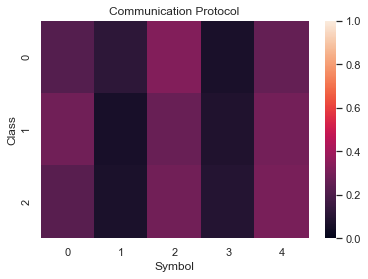

In [223]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

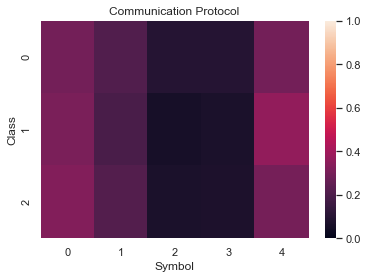

In [224]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

## Zero-shot Coordination

In [211]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)
loss = complete_loss_fn(outputs, targets)
loss.numpy().mean()

1.0808975

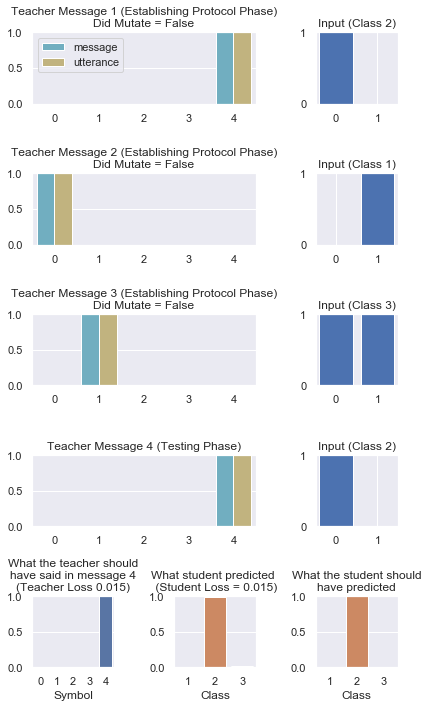

In [215]:
plot_game(inputs, outputs, targets, select_batch=1)

In [209]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)
loss = complete_loss_fn(outputs, targets)
loss.numpy().mean()

1.0403831

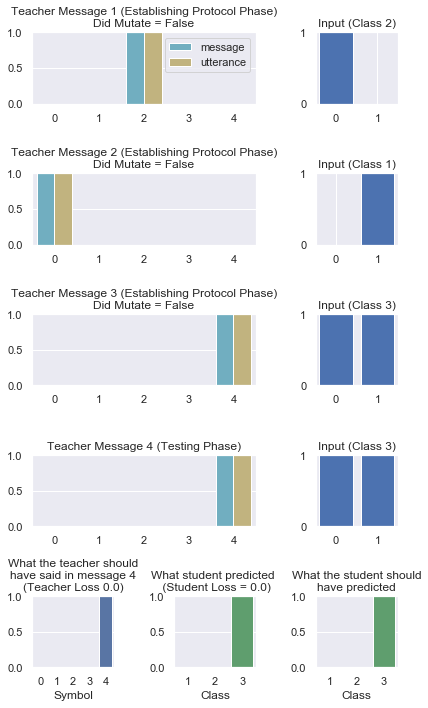

In [210]:
plot_game(inputs, outputs, targets)